In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

<AxesSubplot:xlabel='Class_att', ylabel='count'>

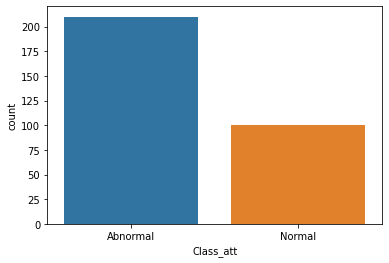

In [2]:
df = pd.read_csv("Dataset_spine.csv")
df.head()
#310 Observations, 13 Attributes (12 Numeric Predictors, 1 Binary Class Attribute - No Demographics)

sns.countplot(x = 'Class_att', data=df)

In [3]:

df['Class_att'] = df['Class_att'].astype('category')
encode_map = {
    'Abnormal': 1,
    'Normal': 0
}

df['Class_att'].replace(encode_map, inplace=True)



In [4]:
X = df.iloc[:, 0:-2]
y = df.iloc[:, -2]


In [5]:
# Train Test Split
# We now split our data into train and test sets. We’ve selected 33% percent of out data to be in the test set.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=69)

In [6]:
# Standardize Input
# For neural networks to train properly, we need to standardize the input values. 
# We standardize features by removing the mean and scaling to unit variance. T

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(X_train.shape)


(207, 12)


In [7]:
# Model Parameters

EPOCHS = 50
BATCH_SIZE = 64
LEARNING_RATE = 0.001


In [8]:
# Define Custom Dataloaders

## train data
class TrainData(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_data = TrainData(torch.FloatTensor(X_train), 
                       torch.FloatTensor(y_train))


## test data    
class TestData(Dataset):    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

test_data = TestData(torch.FloatTensor(X_test))

In [9]:
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

In [10]:
class BinaryClassification(nn.Module):
    def __init__(self):
        super(BinaryClassification, self).__init__()        # Number of input features is 12.
        self.layer_1 = nn.Linear(12, 64) 
        self.layer_2 = nn.Linear(64, 64)
        self.layer_out = nn.Linear(64, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(64)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x
    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)    

cuda:0


In [11]:
model = BinaryClassification()
model.to(device)
print(model)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

BinaryClassification(
  (layer_1): Linear(in_features=12, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [12]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [13]:
model.train()
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        

    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

Epoch 001: | Loss: 0.73083 | Acc: 49.250
Epoch 002: | Loss: 0.60701 | Acc: 67.250
Epoch 003: | Loss: 0.52536 | Acc: 76.000
Epoch 004: | Loss: 0.52768 | Acc: 75.000
Epoch 005: | Loss: 0.47416 | Acc: 75.500
Epoch 006: | Loss: 0.42898 | Acc: 81.750
Epoch 007: | Loss: 0.43073 | Acc: 78.750
Epoch 008: | Loss: 0.40748 | Acc: 77.250
Epoch 009: | Loss: 0.36950 | Acc: 85.250
Epoch 010: | Loss: 0.37452 | Acc: 83.500
Epoch 011: | Loss: 0.35933 | Acc: 84.750
Epoch 012: | Loss: 0.32784 | Acc: 89.250
Epoch 013: | Loss: 0.42771 | Acc: 80.500
Epoch 014: | Loss: 0.31136 | Acc: 89.750
Epoch 015: | Loss: 0.31985 | Acc: 88.500
Epoch 016: | Loss: 0.30742 | Acc: 88.000
Epoch 017: | Loss: 0.27564 | Acc: 92.250
Epoch 018: | Loss: 0.31520 | Acc: 88.500
Epoch 019: | Loss: 0.31406 | Acc: 91.750
Epoch 020: | Loss: 0.24970 | Acc: 94.250
Epoch 021: | Loss: 0.27328 | Acc: 92.000
Epoch 022: | Loss: 0.24837 | Acc: 90.000
Epoch 023: | Loss: 0.23508 | Acc: 91.250
Epoch 024: | Loss: 0.22006 | Acc: 93.750
Epoch 025: | Los

In [14]:
y_pred_list = []
model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

print(y_pred_list)

[1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0]


In [15]:
#confusion_matrix
confusion_matrix(y_test, y_pred_list)
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

           0       0.66      0.74      0.70        31
           1       0.88      0.83      0.86        72

    accuracy                           0.81       103
   macro avg       0.77      0.79      0.78       103
weighted avg       0.81      0.81      0.81       103



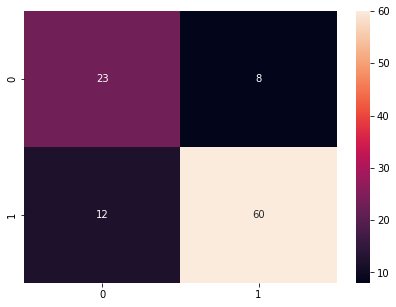

In [16]:

confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred_list))

fig, ax = plt.subplots(figsize=(7,5))         
sns.heatmap(confusion_matrix_df, annot=True, ax=ax)
plt.show()